In [1]:
import pandas as pd

df = pd.read_excel("Nifty 50 Historical Data (1).xlsx")

df = df[['Date', 'Price']].copy()
df = df.sort_values(by='Date').reset_index(drop=True)

import numpy as np
df['log_return'] = np.log(df['Price'] / df['Price'].shift(1))
df = df.dropna().reset_index(drop=True)

In [2]:
from arch import arch_model

garch11 = arch_model(
    df['log_return'],
    mean='Constant',
    vol='GARCH',
    p=1,
    q=1,
    dist='normal'
)

garch_result = garch11.fit(disp='off')
garch_result.summary()


C:\Users\aronn\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001059. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                8924.12
Distribution:                  Normal   AIC:                          -17840.2
Method:            Maximum Likelihood   BIC:                          -17816.7
                                        No. Observations:                 2682
Date:                Tue, Jan 06 2026   Df Residuals:                     2681
Time:                        22:37:03   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         6.6348e-04  2.173e-05     30.537 8.407e-205 [6.209e-04,7.061e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.1181e-06  1.636e-11  1.295e+05      0.000 [2.118e-06,2.118e-06]
alpha[1]       0.1000  1.994e-02      5.014  5.332e-07   [6.091e-02,  0.139]
beta[1]        0.8800  1.488e-02     59.125      0.000     [  0.851,  0.909]
============================================================================

Covariance estimator: robust
"""

## Standardized Residuals

Standardized residuals are examined to verify that the GARCH model has
adequately captured conditional heteroskedasticity.

In [3]:
std_resid = garch_result.std_resid
std_resid.head()


0    0.405297
1    0.388624
2    1.048676
3    1.035086
4   -0.031173
Name: std_resid, dtype: float64

## Residual Behavior

A time-series plot of standardized residuals is used to visually assess
remaining volatility clustering or structural anomalies.

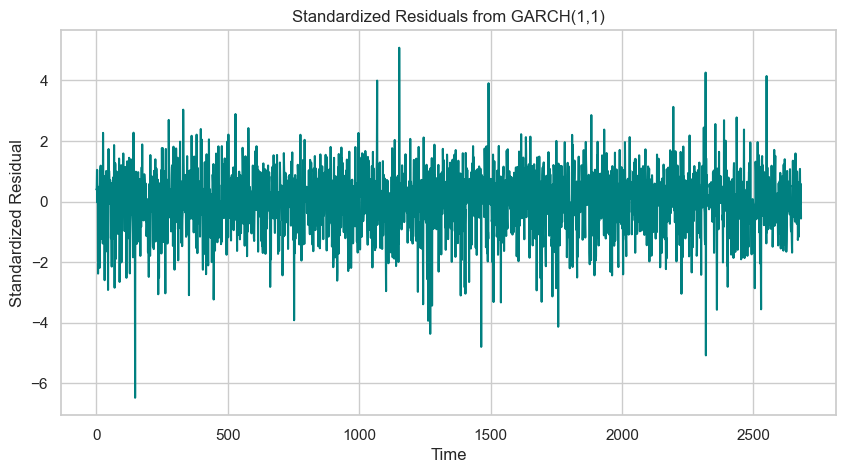

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Set the visual theme for a professional look
sns.set_theme(style="whitegrid")

# 2. Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=std_resid, color='teal')

# 3. Add labels and title
plt.title('Standardized Residuals from GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Standardized Residual')

plt.show()

## Autocorrelation Testing

The Ljung–Box test is applied to standardized residuals to check for
remaining serial correlation.

In [5]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(std_resid, lags=[10], return_df=True)
lb_test


,lb_stat,lb_pvalue
10,20.255,0.026931


## Remaining ARCH Effects

An ARCH LM test on standardized residuals is conducted to confirm that
no additional conditional heteroskedasticity remains unmodeled.

In [6]:
from statsmodels.stats.diagnostic import het_arch

arch_test_resid = het_arch(std_resid)
arch_test_resid

(np.float64(9.843937194294798),
 np.float64(0.45429038162015734),
 0.983966238493608,
 0.45497367914900144)